# Explainability – Turning Risk Scores into Business Decisions

This notebook focuses on **model explainability**:
understanding *why* transactions are flagged as risky
and how these explanations support **business trust and decision-making**.

The goal is not technical curiosity,
but to make fraud predictions **actionable and explainable** for stakeholders.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import shap

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

# Load dataset
paths = ["data/creditcard.csv", "creditcard.csv"]
data_path = next((p for p in paths if os.path.exists(p)), None)

if data_path is None:
    raise FileNotFoundError("creditcard.csv not found.")

df = pd.read_csv(data_path)
df.shape


(284807, 31)

## Why Explainability Matters

In fraud detection, models do not operate in isolation.
Their outputs influence:
- customer experience,
- operational workflows,
- regulatory compliance.

Without explainability:
- risk teams cannot trust the model,
- false positives cannot be challenged,
- decisions become hard to justify.

Explainability bridges the gap between **prediction** and **decision**.


In [3]:
X = df.drop(columns=["Class"])
y = df["Class"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)


In [4]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


## SHAP – Model Explainability Framework

SHAP (SHapley Additive exPlanations) explains model predictions by:
- assigning each feature a contribution value,
- showing how features push predictions higher or lower.

From a business perspective:
- SHAP answers *why* a transaction is risky,
- not just *how risky* it is.


In [5]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)


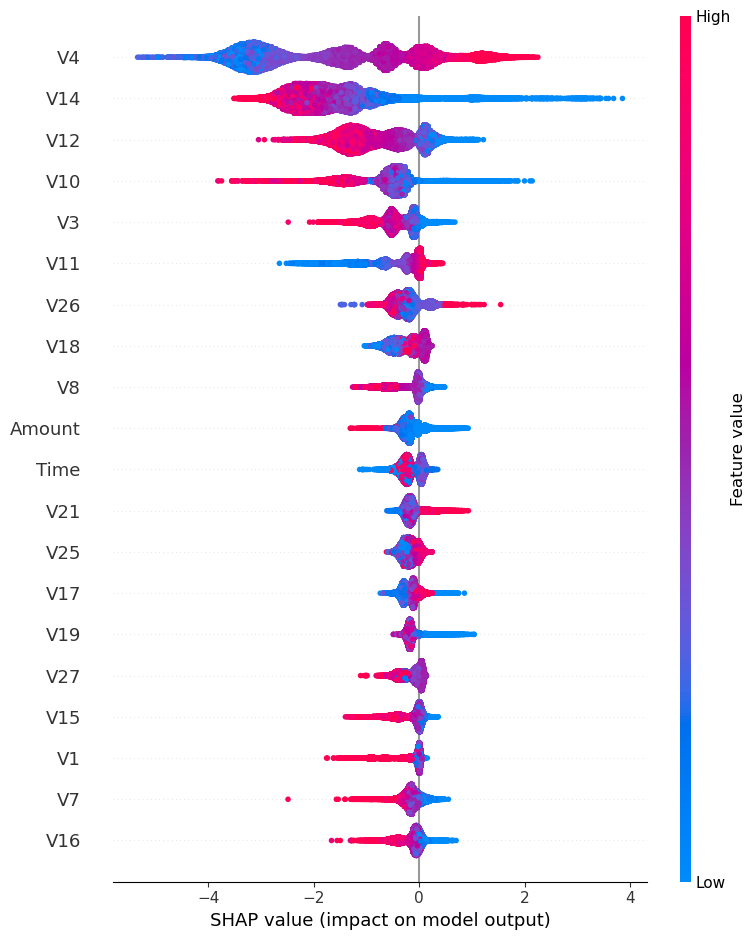

In [6]:
shap.summary_plot(shap_values, X_test, feature_names=X.columns)


## Global Risk Drivers – Business Interpretation

This plot highlights the **most influential risk drivers** across all transactions.

Key insights:
- Certain features consistently push transactions toward higher risk.
- Fraud risk is rarely driven by a single factor.
- Risk emerges from **patterns and combinations**, not simple thresholds.

Business takeaway:
Static rules fail because fraud is multi-dimensional.


In [7]:
mean_abs_shap = np.abs(shap_values).mean(axis=0)

feature_importance = (
    pd.DataFrame({
        "feature": X.columns,
        "mean_abs_shap_value": mean_abs_shap
    })
    .sort_values("mean_abs_shap_value", ascending=False)
)

feature_importance.head(10)


,feature,mean_abs_shap_value
4,V4,1.826156
14,V14,1.721884
12,V12,0.846369
10,V10,0.676798
3,V3,0.448016
11,V11,0.411200
26,V26,0.302332
18,V18,0.267254
8,V8,0.226380
29,Amount,0.210875


## Explaining Individual Decisions

Beyond global patterns, risk teams need to understand:
**why a specific transaction was flagged**.

This is critical for:
- manual review decisions,
- customer disputes,
- internal audits.


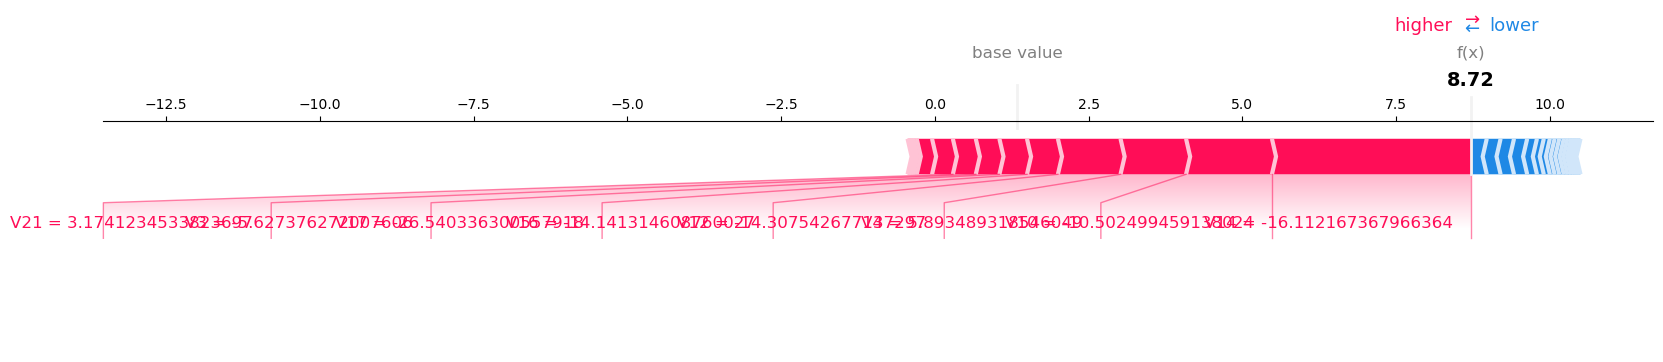

In [8]:
# Explain a single high-risk transaction
idx = np.argmax(xgb_model.predict_proba(X_test)[:, 1])

shap.force_plot(
    explainer.expected_value,
    shap_values[idx],
    X_test[idx],
    feature_names=X.columns,
    matplotlib=True
)


## Local Explanation – Business View

This explanation shows:
- which features increased fraud risk,
- which features reduced it,
- how they combine into a final risk score.

Business value:
- reviewers can validate decisions,
- false positives can be challenged,
- trust in the model increases.


## Explainability as a Decision Tool

Explainability enables:
- **tiered decisions** (block / review / allow),
- better calibration of thresholds,
- faster reviewer decisions.

Instead of asking *“Is the model correct?”*,
teams ask *“Does this decision make sense?”*.


## Key Takeaways

- Explainability is essential for deploying fraud models in production.
- SHAP translates model outputs into human-understandable risk drivers.
- Global explanations guide policy and rule refinement.
- Local explanations support operational decisions and trust.

> A fraud model that cannot explain itself
> cannot be trusted at scale.
